Here I want to try magnetic triangulation using scalar values: either magnetic field strength or a particular component. The result will still be a vector.

In [1]:
from tensorflow import keras
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Load datasets

# For training
X_train = np.load('data/X_train.npy')
Y_train = np.load('data/Y_train.npy')

# For validation
X_val = np.load('data/X_val.npy')
Y_val = np.load('data/Y_val.npy')

X_test = np.load('data/X_test.npy')
Y_test = np.load('data/Y_test.npy')
# Use average field as a baseline model
Y_base = X_test.mean(axis=1)

In [3]:
# Callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(patience=500, monitor='val_loss',restore_best_weights=True) # Stop training if validation loss is not improving
learning_rate_cb = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=300) # Reduce learning rate is the validation loss is not improving

# Mixed configuration: XYYZ-ZXXY
Here, different sensors measure different components. I use XYYZ-ZXXY pattern, i.g., 1st measures X, 2d measures Y, 3d measures Y, etc.

In [4]:
# Create the training data with appropriate shuffle
shape = np.shape(X_train[:,:,0])
X_train_mixed, X_val_mixed, X_test_mixed = np.zeros(shape), np.zeros(shape), np.zeros(shape)

mask = [0, 1, 1, 2, 2, 0, 0, 1]

for i in range(len(mask)):
    X_train_mixed[:,i] = X_train[:,i,mask[i]]
    X_val_mixed[:,i]  = X_val[:,i,mask[i]]
    X_test_mixed[:,i]  = X_test[:,i,mask[i]]


In [5]:
model_m = keras.models.Sequential([
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dense(32,activation='relu'),
    keras.layers.Dense(3)
])
# Compile model
model_m.compile(loss="mae", optimizer = keras.optimizers.Adam(),metrics=["mae"])

In [6]:
# Train
history = model_m.fit(X_train_mixed, Y_train, epochs=5000, validation_data=(X_val_mixed, Y_val), batch_size=16, callbacks=[early_stopping_cb, learning_rate_cb], verbose=False)

Text(0, 0.5, 'mae')

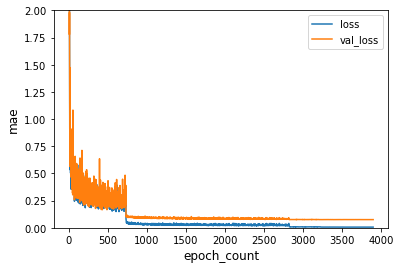

In [7]:
# Plot
h_cnn = history.history
history_df = pd.DataFrame(history.history)
ax= history_df.loc[:, ['loss', 'val_loss']].plot();
ax.set_ylim(0,2)
ax.set_xlabel(r'epoch_count',fontsize=12)
ax.set_ylabel(r'mae',fontsize=12)

8/8 [==============================] - 2s 2ms/step


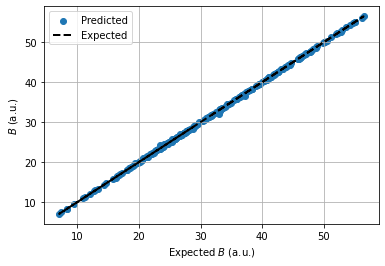

In [8]:
# Apply model to predict the target field
Y_pred = model_m.predict(X_test_mixed)

fig, ax = plt.subplots()
ax.scatter(np.sqrt((Y_test**2).sum(axis=1)), np.sqrt((Y_pred**2).sum(axis=1)), label = 'Predicted')
ax.plot(np.sqrt((Y_test**2).sum(axis=1)), np.sqrt((Y_test**2).sum(axis=1)), linewidth=2.0, ls='--', label = 'Expected', color = 'black')
ax.set_ylabel(r'$B$ (a.u.)')
ax.set_xlabel(r'Expected $B$ (a.u.)')
ax.legend(loc=0)
ax.grid()